__IMPORTING THE LIBRARIES__


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import ppscore as pps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import mutual_info_classif
import shap
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.stats import zscore
import math


__IMPORTING THE CSV FILE__


In [2]:
df = pd.read_csv("Fraud.csv")

In [3]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


__EXPLORATORY DATA ANALYSIS__

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df.shape

(6362620, 11)

***using label encoder as steps done in the future need numeric columns only***

In [7]:
def labelencoder(df):
    encoders = {}
    col = df.select_dtypes(include='object').columns
    for i in col:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
        encoders[i] = le  # Save encoder for that column
    return df, encoders



In [8]:
df, encoders = labelencoder(df)


In [9]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


__NOW THE REAL HUNT FOR INSIGHTS BEGINS__

***1) Correlation Table***

In [1]:
cor = df.corr()
cor_table = cor['isFraud'].sort_values(ascending=False)
print(cor_table)

NameError: name 'df' is not defined

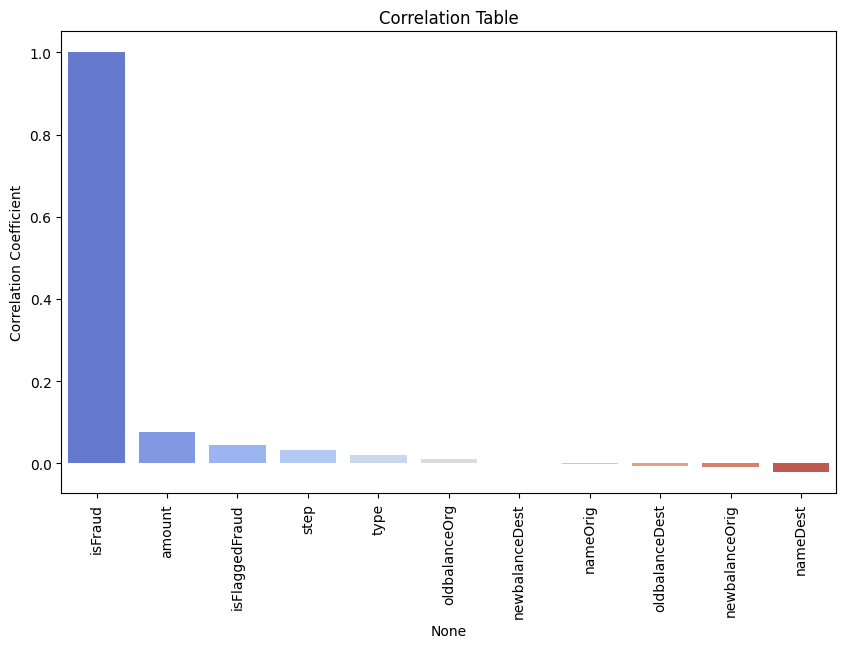

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cor_table.index, y=cor_table.values, hue=cor_table.index, palette="coolwarm", legend=False)
plt.xticks(rotation=90)
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Table")
plt.show()

***2) Pps Score***

In [12]:
ppsx = [col for col in df.columns if col != 'isFraud']
ppsy = 'isFraud'

print(ppsx)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


In [13]:
pps_scores = {col: pps.score(df, col, 'isFraud')["ppscore"] for col in ppsx}
pps_df = pd.DataFrame(pps_scores.items(), columns=['Feature', 'PPS'])
print(pps_df.sort_values(by="PPS", ascending= True))

          Feature  PPS
0            step    0
1            type    0
2          amount    0
3        nameOrig    0
4   oldbalanceOrg    0
5  newbalanceOrig    0
6        nameDest    0
7  oldbalanceDest    0
8  newbalanceDest    0
9  isFlaggedFraud    0


***3) Variance Inflation Factor***

In [14]:
vif_x = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']

dfx = df[vif_x]

x_const = add_constant(dfx)
vif_data = pd.DataFrame()
vif_data["Feature"] = dfx.columns
vif_data["VIF"] = [variance_inflation_factor(x_const.values, i + 1) for i in range(len(dfx.columns))]  # +1 because of constant at index 0

print(vif_data.sort_values(by="VIF", ascending=False))

          Feature         VIF
5  newbalanceOrig  468.010508
4   oldbalanceOrg  462.607845
8  newbalanceDest   75.806088
7  oldbalanceDest   65.980405
2          amount    3.774661
1            type    1.939473
6        nameDest    1.675392
0            step    1.002531
9  isFlaggedFraud    1.000610
3        nameOrig    1.000001


***4) Mutual Information***

In [15]:
mi_x = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
mi_x = df[mi_x]
mi_y = df['isFraud'] 

In [16]:
mi_scores = mutual_info_classif(mi_x, mi_y, discrete_features='auto')
mi_df = pd.DataFrame({'Feature': mi_x.columns, 'MI Score': mi_scores})
print(mi_df.sort_values(by='MI Score', ascending=False))

          Feature  MI Score
1            type  0.119829
0            step  0.010875
4   oldbalanceOrg  0.002610
2          amount  0.002447
6        nameDest  0.000885
5  newbalanceOrig  0.000659
7  oldbalanceDest  0.000166
8  newbalanceDest  0.000099
9  isFlaggedFraud  0.000033
3        nameOrig  0.000000


***5) Outlier by Z Score***

In [17]:
non_fraud = df[df['isFraud'] == 0]
fraud = df[df['isFraud'] == 1]

z_scores = non_fraud.apply(zscore)
filtered_non_fraud = non_fraud[(z_scores < 3).all(axis=1)]
df_clean1 = pd.concat([filtered_non_fraud, fraud])

***6) Outlier by IQR***

In [18]:
def remove_outliers_iqr(df, target='isFraud'):
    df_no_out = df.copy()
    for col in df.select_dtypes(include='number').columns:
        if col == target:
            continue
        Q1 = df_no_out[col].quantile(0.25)
        Q3 = df_no_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        mask = ~((df_no_out[target] == 0) & ((df_no_out[col] < lower) | (df_no_out[col] > upper)))
        df_no_out = df_no_out[mask]
    return df_no_out


***7) Group Based Analysis on Type Feature***

In [20]:
type_mapping = dict(zip(encoders['type'].classes_, encoders['type'].transform(encoders['type'].classes_)))
print(type_mapping)

{'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}


C:\Users\ketan\AppData\Local\Temp\ipykernel_2132\2184766859.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_rate_by_type, x='type', y='isFraud', palette='Reds_r')


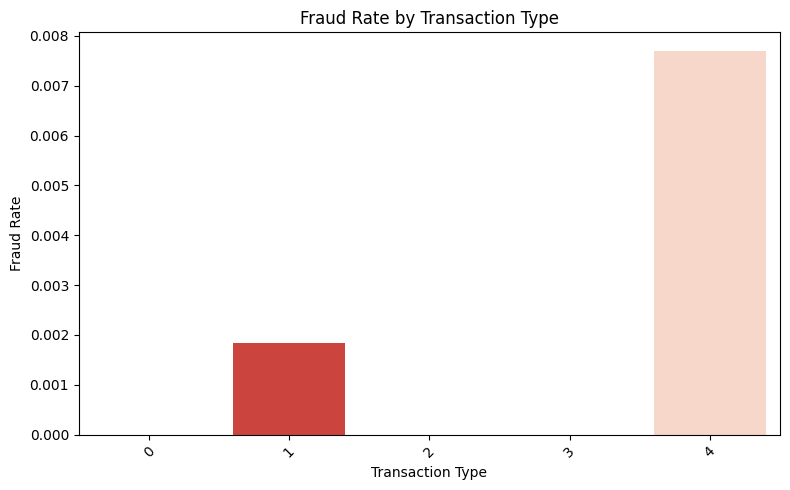

In [21]:
fraud_rate_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False).reset_index()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=fraud_rate_by_type, x='type', y='isFraud', palette='Reds_r')
plt.title("Fraud Rate by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***7) Group Based Analysis on Step Feature***

In [22]:
totalsteps = len(df['step'].value_counts())
total1 = len(df[df['isFraud'] == 1])

In [23]:
fraud_count_by_step = df[df['isFraud'] == 1].groupby('step').size().reset_index(name='count')
average_fraud_count = fraud_count_by_step['count'].mean()
above_avg_fraud = fraud_count_by_step[fraud_count_by_step['count'] > average_fraud_count]
above_avg_fraud = above_avg_fraud.sort_values(by='count', ascending=False).reset_index(drop=True)
above_avg_fraud.head(326)

,step,count
0,212,40
1,523,30
2,501,28
3,387,28
4,425,28
...,...,...
321,579,12
322,206,12
323,577,12
324,214,12


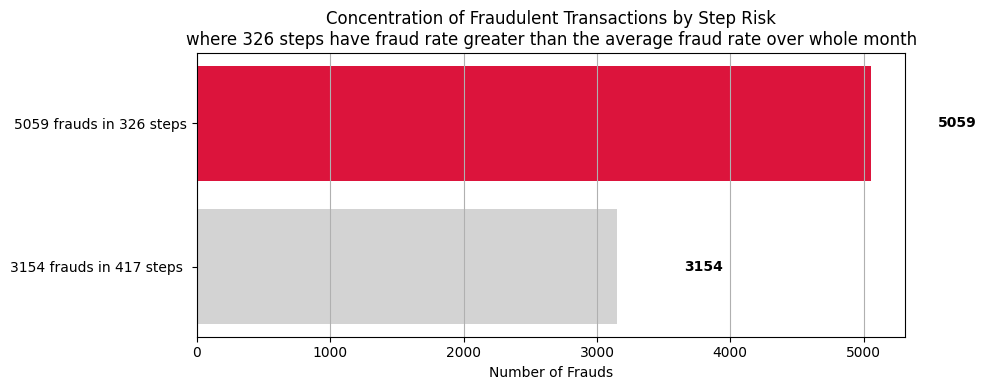

In [24]:
total_count = above_avg_fraud['count'].sum()
fraud_counts = [total1 - total_count, total_count]
step_counts = [totalsteps - 326, 326]
labels = [
    f"{total1 - total_count} frauds in {totalsteps - 326} steps ",
    f"{total_count} frauds in 326 steps"
]
colors = ['lightgray', 'crimson']

# Plot
plt.figure(figsize=(10, 4))
bars = plt.barh(labels, fraud_counts, color=colors)

# Annotate
for bar in bars:
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2,
             f"{width}", va='center', fontweight='bold')

plt.title("Concentration of Fraudulent Transactions by Step Risk\nwhere 326 steps have fraud rate greater than the average fraud rate over whole month")
plt.xlabel("Number of Frauds")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

***8) Group Based Analysis on Amount***

C:\Users\ketan\AppData\Local\Temp\ipykernel_2132\3862166196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['mid_amount_range'] = pd.cut(fraud_df['amount'], bins=bin_edges_1to10M, labels=labels_1to10M, right=False)


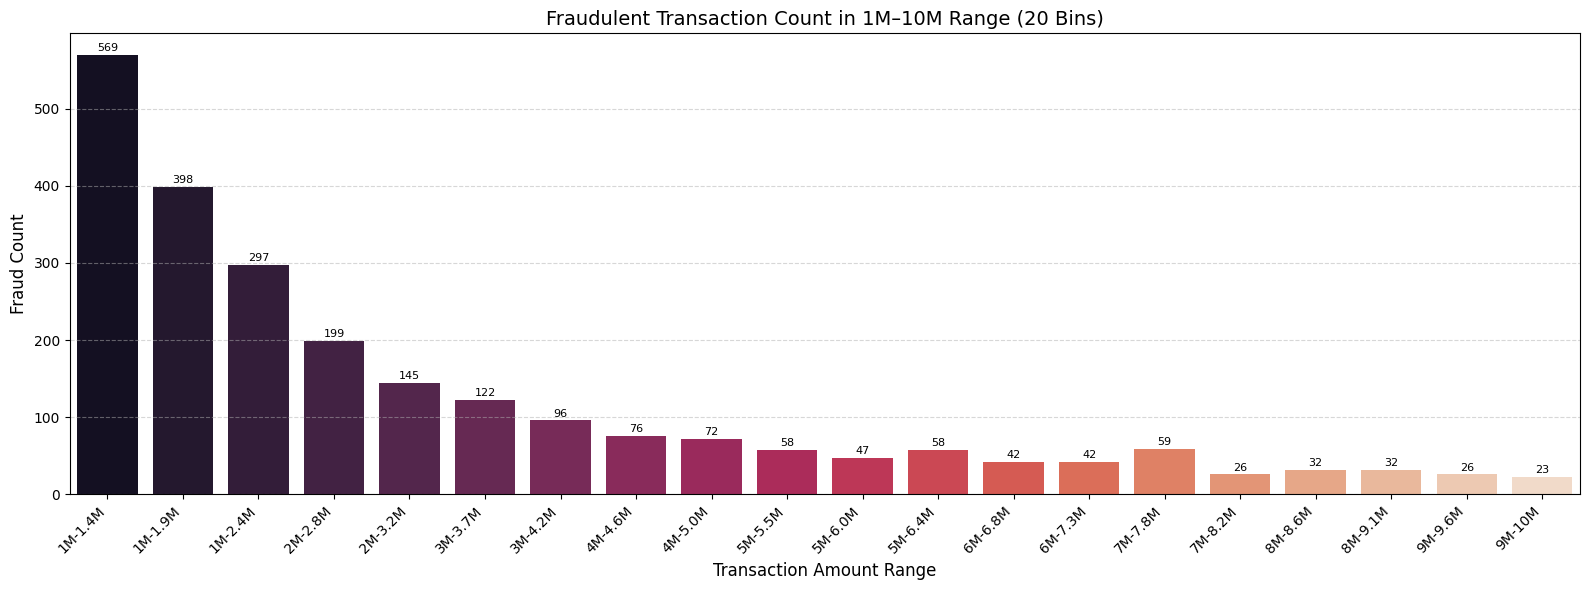

In [26]:
fraud_df = df[df['isFraud'] == 1]
bin_edges_1to10M = np.linspace(1_000_000, 10_000_000, 21)
labels_1to10M = [f"{int(bin_edges_1to10M[i]/1e6)}M-{int(bin_edges_1to10M[i+1]/1e6)}M"
                 if bin_edges_1to10M[i+1] % 1e6 == 0
                 else f"{int(bin_edges_1to10M[i]/1e6)}M-{round(bin_edges_1to10M[i+1]/1e6,1)}M"
                 for i in range(len(bin_edges_1to10M)-1)]

fraud_df['mid_amount_range'] = pd.cut(fraud_df['amount'], bins=bin_edges_1to10M, labels=labels_1to10M, right=False)

mid_range_counts_df = fraud_df['mid_amount_range'].value_counts().sort_index().reset_index()
mid_range_counts_df.columns = ['Amount Range', 'Fraud Count']

plt.figure(figsize=(16, 6))
sns.barplot(data=mid_range_counts_df, x='Amount Range', y='Fraud Count', hue='Amount Range', palette="rocket", legend=False)

for i, count in enumerate(mid_range_counts_df['Fraud Count']):
    plt.text(i, count + 5, str(count), ha='center', fontsize=8)

# Labels and formatting
plt.title("Fraudulent Transaction Count in 1M–10M Range (20 Bins)", fontsize=14)
plt.xlabel("Transaction Amount Range", fontsize=12)
plt.ylabel("Fraud Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\ketan\AppData\Local\Temp\ipykernel_2132\3368021652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['low_amount_range'] = pd.cut(fraud_df['amount'], bins=bin_edges, labels=labels, right=False)


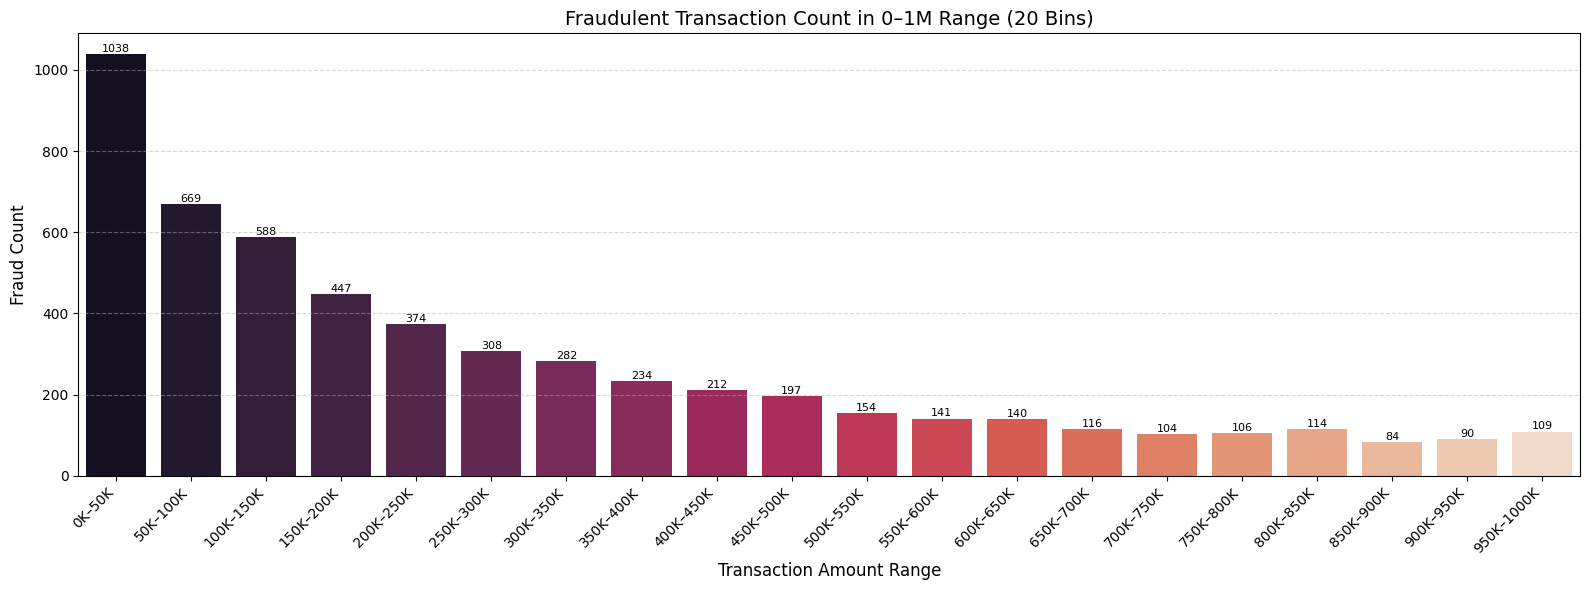

In [27]:
bin_edges = np.linspace(0, 1_000_000, 21)  # 21 edges = 20 bins
labels = [f"{int(bin_edges[i]/1000)}K–{int(bin_edges[i+1]/1000)}K" for i in range(len(bin_edges)-1)]

fraud_df['low_amount_range'] = pd.cut(fraud_df['amount'], bins=bin_edges, labels=labels, right=False)

low_range_counts_df = fraud_df['low_amount_range'].value_counts().sort_index().reset_index()
low_range_counts_df.columns = ['Amount Range', 'Fraud Count']

plt.figure(figsize=(16, 6))
sns.barplot(data=low_range_counts_df, x='Amount Range', y='Fraud Count', hue='Amount Range', palette="rocket", legend=False)

for i, count in enumerate(low_range_counts_df['Fraud Count']):
    plt.text(i, count + 5, str(count), ha='center', fontsize=8)

# Labels and formatting
plt.title("Fraudulent Transaction Count in 0–1M Range (20 Bins)", fontsize=14)
plt.xlabel("Transaction Amount Range", fontsize=12)
plt.ylabel("Fraud Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

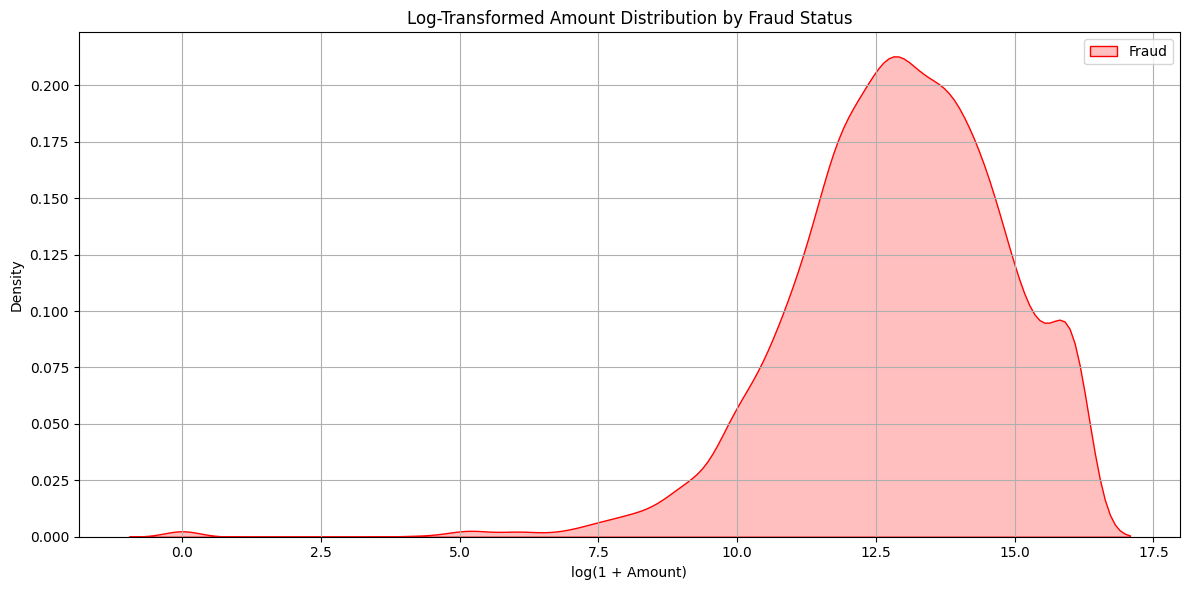

In [28]:
df['log_amount'] = np.log1p(df['amount'])  # log(1 + amount) to avoid log(0)

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['isFraud'] == 1], x='log_amount', label='Fraud', fill=True, color='red')
plt.title("Log-Transformed Amount Distribution by Fraud Status")
plt.xlabel("log(1 + Amount)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
bin_edges = np.arange(0, 13_000_000 + 10_000, 10_000)
labels = [f"{int(start/1000)}K–{int(end/1000)}K" for start, end in zip(bin_edges[:-1], bin_edges[1:])]

fraud_df = df[df['isFraud'] == 1].copy()

fraud_df['amount_range'] = pd.cut(fraud_df['amount'], bins=bin_edges, labels=labels, right=False)

range_counts = fraud_df['amount_range'].value_counts().sort_values(ascending=False).reset_index()
range_counts.columns = ['Amount Range', 'Fraud Count']

# Display the sorted ranges
print(range_counts.head(17))

     Amount Range  Fraud Count
0   10000K–10010K          287
1          0K–10K          278
2         20K–30K          211
3         10K–20K          188
4         30K–40K          181
5         40K–50K          180
6         70K–80K          158
7         50K–60K          148
8       100K–110K          132
9         60K–70K          126
10      120K–130K          126
11        80K–90K          125
12      110K–120K          124
13      170K–180K          116
14      140K–150K          115
15       90K–100K          112
16      150K–160K          106


***9) Group Based Analysis On NameDest***

In [36]:
len(df['nameDest'].value_counts())

2722362

In [39]:
fraud_df = df[df['isFraud'] == 1]

fraud_count_by_nameDest = fraud_df['nameDest'].value_counts().reset_index()
fraud_count_by_nameDest.columns = ['nameDest', 'Fraud Count']

fraud_count_by_nameDest[fraud_count_by_nameDest['Fraud Count'] == 2]

,nameDest,Fraud Count
0,57504,2
1,11957,2
2,296180,2
3,147473,2
4,178026,2
5,193961,2
6,301992,2
7,193439,2
8,4005,2
9,334402,2


__FEATURE ENGINEERING__

In [40]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'log_amount'],
      dtype='object')

In [41]:
df['new_net_bal'] = df['newbalanceDest'] - df['newbalanceOrig']
df['old_net_bal'] = df['oldbalanceDest'] - df['oldbalanceOrg']

In [42]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'log_amount', 'new_net_bal', 'old_net_bal'],
      dtype='object')

In [43]:
df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest'], inplace=True)
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'isFraud', 'isFlaggedFraud',
       'log_amount', 'new_net_bal', 'old_net_bal'],
      dtype='object')

In [44]:
df.head(10)

,step,type,amount,nameOrig,isFraud,isFlaggedFraud,log_amount,new_net_bal,old_net_bal
0,1,3,9839.64,757869,0,0,9.194276,-160296.36,-170136.00
1,1,3,1864.28,2188998,0,0,7.531166,-19384.72,-21249.00
2,1,4,181.00,1002156,1,0,5.204007,0.00,-181.00
3,1,1,181.00,5828262,1,0,5.204007,0.00,21001.00
4,1,3,11668.14,3445981,0,0,9.364703,-29885.86,-41554.00
5,1,3,7817.71,6026525,0,0,8.964275,-46042.29,-53860.00
6,1,3,7107.77,1805947,0,0,8.869085,-176087.23,-183195.00
7,1,3,7861.64,2999171,0,0,8.969878,-168225.59,-176087.23
8,1,3,4024.36,869140,0,0,8.300370,0.00,-2671.00
9,1,2,5337.77,5407276,0,0,8.582751,3966.56,178.00


***Again Checking the Collinearty, MI_score***

In [46]:
df.drop(columns='log_amount', inplace=True)
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'isFraud', 'isFlaggedFraud',
       'new_net_bal', 'old_net_bal'],
      dtype='object')

In [ ]:
ss = StandardScaler()
scale = []